In [18]:
import jittor as jt
from jittor import nn, Module
import pygmtools
import jittor.transform as trans
pygmtools.BACKEND = 'jittor'

<h2>Model<h2>

In [9]:
# 论文使用的AlexNet
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.mod = nn.Sequential(
            nn.Conv2d(3, 64, 11, 2, 5),#(64,8,8)
            nn.Relu(),
            nn.MaxPool2d(2, 2),#(64,4,4)
            nn.Conv2d(64, 192, 5, 1, 2), #(192,4,4)
            nn.Relu(),
            nn.MaxPool2d(2, 2),#(192,2,2)
            nn.Conv2d(192, 384, 3, 1, 1),#(384,2,2)
            nn.Relu(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.Relu(),
            nn.Conv2d(256, 256, 3, 1, 1),#(256,2,2)
            nn.Relu(),
            nn.AvgPool2d(2, 2), #(400,256,1,1)
            nn.Flatten(), #(400,256)
            nn.Linear(256, 512),   
            nn.BatchNorm(512),
            nn.Relu(),
        )

    def execute(self, x):
        x = self.mod(x)
        return x

#改进后的CNN网络
class ModelCNN(Module):
    def __init__ (self):
        super (ModelCNN, self).__init__()
        self.mod = nn.Sequential(
            nn.Conv(3, 32, 3, 1, 1),
            nn.BatchNorm(32),
            nn.Relu(),           
            nn.Conv(32, 32, 3, 1, 1),        
            nn.BatchNorm(32),
            nn.Relu(),           
            nn.MaxPool2d(2,2), #(400,32,8,8)
            nn.Conv(32, 64, 3, 1, 1),      
            nn.BatchNorm(64),
            nn.Relu(),           
            nn.Conv(64, 64, 3, 1, 1),    
            nn.BatchNorm(64),
            nn.Relu(),
            nn.MaxPool2d(2,2), #(400,64,4,4)
            nn.Conv(64, 128, 3, 1, 1),    
            nn.BatchNorm(128),
            nn.Relu(),           
            nn.Conv(128, 128, 3, 1, 1), 
            nn.BatchNorm(128),
            nn.Relu(),
            nn.AvgPool2d(2,2), #(400,128,2,2)
            nn.Flatten(),
            nn.Linear(128*2*2, 512),   
            nn.BatchNorm(512),
            nn.Relu(), #(400,512)
        )

    def execute (self, x) :
        x = self.mod(x)
        return x

#DeepPermNet
class Model (Module):
    def __init__(self):
        super(Model, self).__init__()
        #self.modelCNN = AlexNet()
        self.modelCNN = ModelCNN()
        self.DeepPermNet = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048,4096),
            nn.Relu(),
            nn.Linear(4096, 16)
        )
    
    def execute(self, x):
        x = x.view(400, 3, 16, 16) #(400,3,16,16)
        x = self.modelCNN(x) 
        x = x.view(100, 2048) #(100,2048)
        x = self.DeepPermNet(x) 
        x = x.view(100, 4, 4)
        x = pygmtools.sinkhorn(x)
        return x

<h2>DataSet<h2>

In [25]:
import os
import pickle
import numpy as np
from jittor.dataset.dataset import Dataset
#原始类从文件中取出数据集
def CIFAR10(path, types):
    if types == 'train':
        image_list = []
        for i in range(1, 6):
            filename = os.path.join(path, f'data_batch_{i}')
            with open(filename, 'rb') as file:
                data = pickle.load(file, encoding='bytes')
            image_list.append(np.array(data[b'data'], dtype=np.float32).reshape(-1, 3, 32, 32) / 255.0)

    else:
        filename = os.path.join(path, 'test_batch')
        with open(filename, 'rb') as file:
            data = pickle.load(file, encoding='bytes')
        image_list = np.array(data[b'data'], dtype=np.float32).reshape(-1, 3, 32, 32) / 255.0

    image_list = np.concatenate(image_list, axis=0)
    image_list = image_list.reshape(-1, 3, 32, 32)
    index = np.random.permutation(image_list.shape[0])
    return image_list[index]

#继承类实现对图像的切分和打乱
class PermutatedCIFAR10(Dataset):
    def __init__(self, path, types, batch_size=100):
        super().__init__()
        self.path, self.types, self.batch_size = path, types, batch_size
        self.image_list = CIFAR10(self.path, self.types)
        self.set_attrs(batch_size=self.batch_size, shuffle=True)

    def __getitem__(self, label):
        image = self.image_list[label]
        image_permulate = []
        for i in range(2):
            for j in range(2):
                image_permulate.append(image[:,i*(image.shape[1]//2):(i+1)*(image.shape[1]//2),j*(image.shape[2]//2):(j+1)*(image.shape[2]//2)])
        image_per = np.stack(image_permulate, axis=0)
        label = np.random.permutation(4)
        return image_per[label], label

    def __len__(self):
        return self.image_list.shape[0]

<h2>Train and Test<h2>

In [23]:
#定义训练函数
def train(model, dataloader, optimizer, epoch):
    model.train()
    cnt = 0
    for permulated_images, labels in dataloader:
        outputs = model(permulated_images)
        loss = nn.cross_entropy_loss(outputs.view(-1, 4), labels)
        optimizer.step(loss)
        cnt += 1
        train_loss.append(loss.data[0]) #记录数据
        print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(epoch, cnt*100, len(dataloader), loss.data[0]))

#定义测试函数
def test(model, dataloader, epoch):
    model.eval()
    pos_cnt = 0
    perm_cnt = 0
    with jt.no_grad():
        for permulated_images, labels in dataloader:
            outputs = model(permulated_images)
            correct = (outputs.argmax(dim=2)[0] == labels).sum(dim=1)
            pos_cnt += correct.sum().data[0]
            perm_cnt += (correct == 4).sum().data[0]
    pos_acc = pos_cnt / (4 * len(dataloader))
    perm_acc = perm_cnt / len(dataloader)
    test_pos_acc.append(pos_acc)
    test_perm_acc.append(perm_acc) #记录数据
    print('Test Epoch: {}\tTotal Fragment Acc: {:.6f}, Total Permulate Accuray: {:.6f}'.format(epoch, frag_acc, perm_acc))
        

<h2>Main<h2>

In [26]:
epochs = 10
lr = 0.1
batch_size = 100
momentum = 0.9
path = './cifar-10-python/cifar-10-batches-py'
train_loss = []
test_pos_acc = []
test_perm_acc = []
model = Model()
optimizer = nn.Adam(model.parameters(), lr, momentum)
#定义dataloader
loader_train = PermutatedCIFAR10(path=path, types='train' ,batch_size=batch_size)
loader_test = PermutatedCIFAR10(path=path, types='test', batch_size=batch_size)
#开始训练和测试
for epoch in range(epochs):
    train(model, loader_train, optimizer, epoch)
    test(model, loader_test, epoch)

Train Epoch: 0 [100/50000]	Loss: 1.385376
Train Epoch: 0 [200/50000]	Loss: 1.386008
Train Epoch: 0 [300/50000]	Loss: 1.386031


KeyboardInterrupt: 

<h2>Plot<h2>

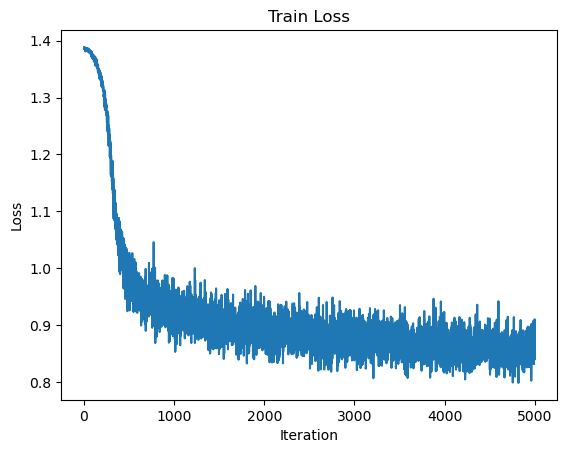

In [6]:
#画结果图
import matplotlib.pyplot as plt
x = np.linspace(1, 5000, 5000)
plt.plot(x, train_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

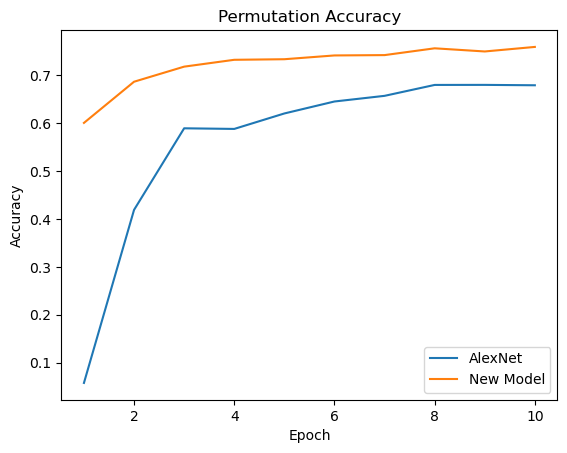

In [10]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
'''
print(test_pos_acc)
print(test_perm_acc)
plt.plot(x, test_frag_acc)
plt.plot(x, test_perm_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend(['Position Accuracy', 'Permutation Accuracy'])
plt.show()
'''
y_alx_frag = [0.324025, 0.654025, 0.7551, 0.74955, 0.771425, 0.786925, 0.795475, 0.8104, 0.8084, 0.809725]
y_alx_per = [0.0576, 0.4191, 0.5895, 0.5882, 0.6205, 0.6455, 0.6573, 0.6801, 0.6802, 0.6794]
y_vgg_frag = [0.769025, 0.816575, 0.836225, 0.84465, 0.844875, 0.849075, 0.85075, 0.8576, 0.854425, 0.85885]
y_vgg_per = [0.6008, 0.6868, 0.7183, 0.7326, 0.7338, 0.7417, 0.7424, 0.7566, 0.75, 0.7595]
plt.plot(x,y_alx_per)
plt.plot(x,y_vgg_per)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Permutation Accuracy')
plt.legend(['AlexNet','New Model'])
plt.show()